# Building a Neural Network

## Data
* MNIST dataset of 28x28 pixels image of handwirtten digits

In [9]:
# get the train and test data
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        # normalizing to -1 to 1
        images = ((images / 255.) - .5) * 2
 
    return images, labels

X_train, y_train = load_mnist('./others/', kind='train')
X_test, y_test = load_mnist('./others/', kind='t10k')

In [13]:
print('Training set: Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Testing set: Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Training set: Rows: 60000, columns: 784
Testing set: Rows: 10000, columns: 784


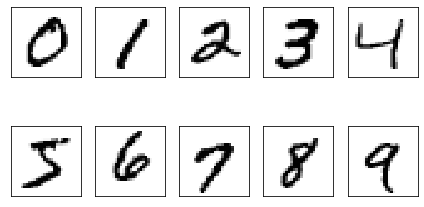

In [18]:
import matplotlib.pyplot as plt

# looking at what the digits look like
# 2 rows, 5 columns
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

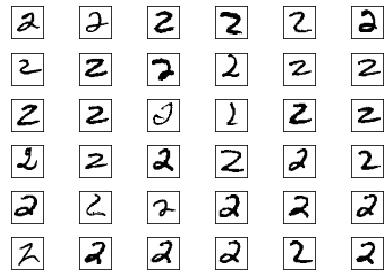

In [21]:
# looking at one particular digit to see how different they look

# looking at 36 of them
fig, ax = plt.subplots(nrows=6, ncols=6, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(36):
    # only look at 2's
    img = X_train[y_train == 2][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

# Making a multi-layer perceptron

From Python Machine Learning book, version 3, Chapter 12

In [22]:
import numpy as np
import sys


class NeuralNetMLP(object):
    # n_hidden : number of hidden unit
    # epochs : number of passes
    # eta : learning rates
    # shuffle = True, preshuffle the data
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        # to avoid vanishing gradient, want to 'clip'
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        z_h = np.dot(X, self.w_h) + self.b_h

        # could also use tanh
        a_h = self._sigmoid(z_h)

        # get the output z

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # activated
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        
        # uses L2 regularization
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))
        
        # pretty standard cost function J with regularizaiton L2
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        
        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        # highest probability is the label
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):

        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]
        
        # setting parameters
        
        # input to hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # hidden to output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])
            
            # puts out live update insetad of printing out the cost and acc of each epoch (pass)

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [23]:
n_epochs = 200

    
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

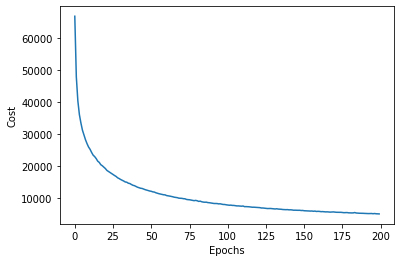

In [24]:
# plotting the cost vs epochs, the cost J should go down

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

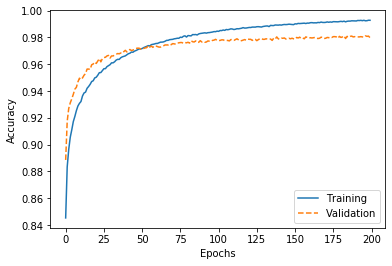

In [26]:
# plotting the training vs validation curves

plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

Test accuracy: 97.54%


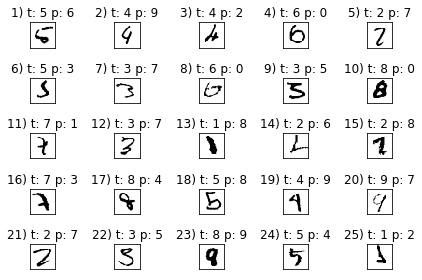

In [28]:
# What did our model misclassified? Manual inspection
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()